In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.models.blei_lafferty_score import BleiLaffertyScore
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config

from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Get dataset

In [5]:
DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"

In [6]:
dataset = Dataset(DATASET_PATH)
dictionary = dataset.get_dictionary()

In [7]:
print(dataset.get_possible_modalities())
dataset.get_dataset().head()

{'@2gramm', '@title', '@snippet', '@3gramm', '@word', '@post_tag', '@author'}


,vw_text,raw_text
id,,
1.txt,1.txt |@author fuchs preobrazhensky tabachniko...,@title Автограф # «Математический дивертисмент...
2.txt,2.txt |@word книга:2 лекция:3 рассматриваться:...,@title Главы: Маскулинности в российском конте...
3.txt,3.txt |@word развитие появляться пиджина:4 бел...,@title Пиджины и креольские языки | @snippet Л...
4.txt,4.txt |@word стандартный задача:3 состоять:4 р...,@title FAQ: Физиология микроводорослей | @snip...
5.txt,5.txt |@2gramm повседневный_практика государст...,@title Русская государственная идеология | @sn...


### Make initial model

In [11]:
with open("/home/sultan/recipes/ARTM_baseline_decorrelate_bigram.yml", "r") as f:
    yaml_string = f.read()

specific_topics = [f'topic_{i}' for i in range(27)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 2)]

yaml_string = yaml_string.format(
    modality_list=['@word', '@post_tag', '@3gramm', '@2gramm'],
    main_modality='@word',
    specific_modality='@2gramm',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described by Murat Apishev
# one of the core programmers of BigARTM library in personal correspondence.
# According to his letter 'decent' topic model can be obtained by
# Decorrelating model topics simultaneously looking at retrieved TopTokens


# Use .format(modality_list=modality_list, main_modality=main_modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, better left to the user to define optimal topic number
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26'] 
    background_topics: ['bcg_27', 'bcg_28']

# Here is exam

### Run experiment

In [12]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./MuratDemo27') == True:
    os.system("rm -rf ./MuratDemo27")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id="MuratDemo27",
    save_path="MuratDemo27"
)

In [13]:
experiment.run(dataset)

{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7f571ef96a90>}

In [14]:
experiment.show()

Experiment MuratDemo27

Experiment was made with BigARTM 0.9.0
Tree:
                                ┌##17h51m34s_18d11m2019y###
                                ├##17h52m34s_18d11m2019y###
                                ├##17h53m32s_18d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──────┤
                                ├##17h54m30s_18d11m2019y###
                                │                                                                                                       ┌##17h57m40s_18d11m2019y###
                                │                                                                                                       ├##17h58m46s_18d11m2019y###
                                │                                                                                                       ├##17h59m53s_18d11m2019y###
                                │                                                                                                       ├##18h00m59s_18d11m2019y###
 

In [15]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

In [16]:
best_model.describe_regularizers()

tau  gamma
model_id                   regularizer_name                           
##18h12m06s_18d11m2019y### smooth_phi_bcg              9.949604    NaN
                           smooth_theta_bcg           93.597598    NaN
                           decorrelation_phi           0.030000    0.0
                           decorrelation_phi_@2gramm   0.120000    0.0

In [17]:
best_model.describe_scores()

last_value
model_id                   score_name                                                                               
##18h12m06s_18d11m2019y### PerplexityScore@all                                                           1.54523e+11
                           SparsityThetaScore                                                              0.0711739
                           SparsityPhiScore@word                                                            0.592966
                           PerplexityScore@word                                                              3530.62
                           TopicKernel@word.average_coherence                                                      0
                           TopicKernel@word.average_contrast                                                0.457987
                           TopicKernel@word.average_purity                                                  0.199831
                           TopicKernel@word.average_size                                                     857.759
                           TopicKernel@word.coherence              {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@word.contrast               {'topic_0': 0.47468170523643494, 'topic_1': 0....
                           TopicKernel@word.purity                 {'topic_0': 0.1418415755033493, 'topic_1': 0.2...
                           TopicKernel@word.size                   {'topic_0': 83.0, 'topic_1': 136.0, 'topic_2':...
                           TopicKernel@word.tokens                 {'topic_0': ['олигархия', 'ксенофонт', 'аристо...
                           SparsityPhiScore@post_tag                                                        0.868076
                           PerplexityScore@post_tag                                                           54.885
                           TopicKernel@post_tag.average_coherence                                                  0
                           TopicKernel@post_tag.average_contrast                                            0.831988
                           TopicKernel@post_tag.average_purity                                              0.930163
                           TopicKernel@post_tag.average_size                                                 35.2069
                           TopicKernel@post_tag.coherence          {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@post_tag.contrast           {'topic_0': 0.8284870386123657, 'topic_1': 0.8...
                           TopicKernel@post_tag.purity             {'topic_0': 0.9570786952972412, 'topic_1': 0.9...
                           TopicKernel@post_tag.size               {'topic_0': 29.0, 'topic_1': 37.0, 'topic_2': ...
                           TopicKernel@post_tag.tokens             {'topic_0': ['эрос', 'декарт_рене', 'платон', ...
                           SparsityPhiScore@3gramm                                                          0.931035
                           PerplexityScore@3gramm                                                            333.444
                           TopicKernel@3gramm.average_coherence                                                    0
                           TopicKernel@3gramm.average_contrast                                             0.0631352
                           TopicKernel@3gramm.average_purity                                               0.0673965
                           TopicKernel@3gramm.average_size                                                   16.9655
                           TopicKernel@3gramm.coherence            {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@3gramm.contrast             {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@3gramm.purity               {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
           

## Results

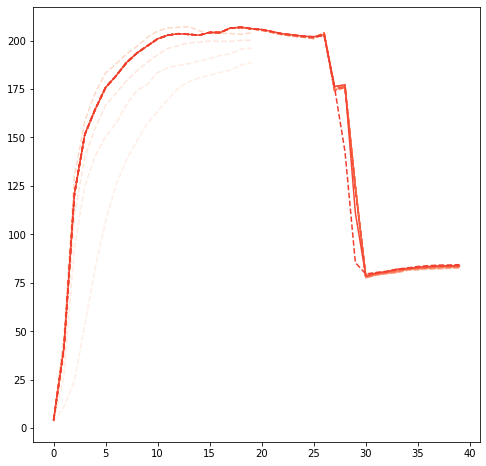

In [18]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['BleiLaffertyScore']
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
plt.show()

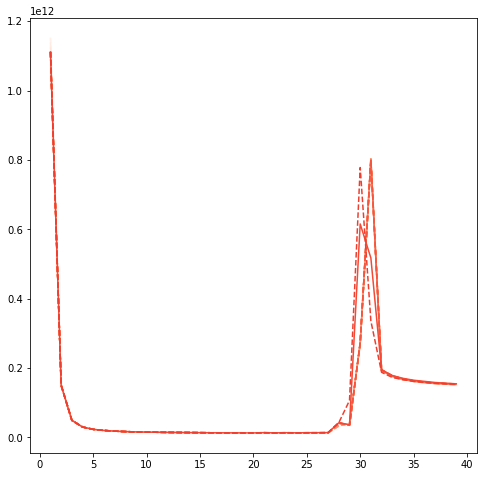

In [19]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    score[0] = float("nan")
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
plt.show()

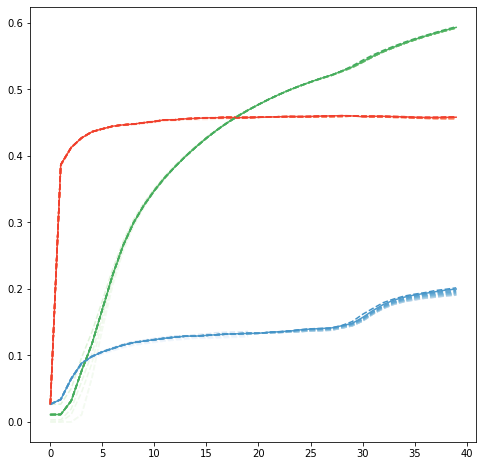

In [20]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]), ls=ls)
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
    
    score = tm.scores['SparsityPhiScore@word']
    plt.plot(score, color=cm.Greens(colors[i]), ls=ls)

plt.show()

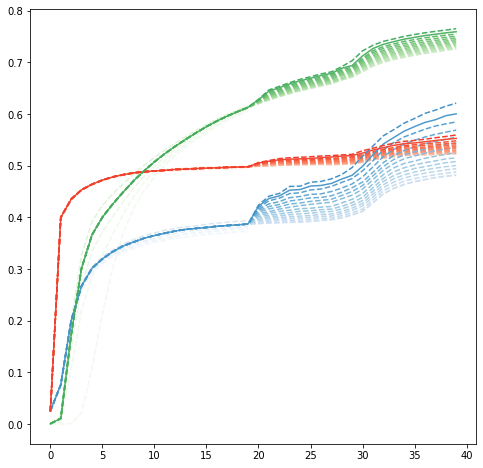

In [21]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    score = tm.scores['TopicKernel@2gramm.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]), ls=ls)
    score = tm.scores['TopicKernel@2gramm.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
    
    score = tm.scores['SparsityPhiScore@2gramm']
    plt.plot(score, color=cm.Greens(colors[i]), ls=ls)

plt.show()

## Investigate model

In [22]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer

In [23]:
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view())
first_model_top_doc = TopDocumentsViewer(best_model, dataset=dataset).view()

In [24]:
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw


n=None
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[:n]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = dataset.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

,topic_0 @2gramm
политический_философия,0.05564
политический_теория,0.02882
научный_революция,0.02724
политический_мысль,0.02201
политический_режим,0.01469
политический_философ,0.01451
лео_штраус,0.0141
мишель_фуко,0.00973
человеческий_природа,0.00927
историк_наука,0.00887


политическая философия эроса о понятии эроса и эрота в дискуссии о тирании у платона, ксенофонта и аристотеля, идеальном правителе и высшей форме страсти

тирания у платона философ александр павлов о политической философии платона, понимании тирании в диалогах «государство» и «законы» и идеальном политическом режиме

тирания у ксенофонта философ александр павлов о диалоге «гиерон», философии ксенофонта в работах лео штрауса и проекте добродетельной тирании

главымеханицизм. декарт конструирует вселенную отрывок из книги «научная революция как событие» историков науки питера деара и стивена шейпина о появлении науки в ее современном понимании

тирания в античной политической философии философ александр павлов о значении худшего политического режима в трудах платона, ксенофонта и аристотеля

что смотреть«мандерлей» ларса фон триера социолог григорий юдин рекомендует фильм, вскрывающий конфликт между теорией и практикой демократии в современном мире

экономические взгляды сократа философ михаил маяцкий о разногласиях между сократом и софистами, плате за образование и представлениях о богатстве в эпоху античности

политическая философия аристотеля историк александр марей об уравнивающей справедливости, понятии полиса и природе рабства

главы # свобода слуг и свобода граждан отрывок из книги знаменитого итальянского политического философа маурицио вироли «свобода слуг»

томас гоббс и эмбриология историк философии павел соколов о концепции естественного состояния, исследованиях женской меланхолии и трактате о теле

,topic_1 @2gramm
нитрид_бора,0.02033
высокий_давление,0.01977
органический_химия,0.01921
кристаллический_структура,0.01773
высокий_температура,0.01724
нобелевский_премия,0.01515
куперовский_пара,0.01127
химический_соединение,0.01125
химический_связь,0.01094
атом_углерод,0.01084


реакция интеркалирования химик виктор авдеев о графитовой матрице, сверхсжатом состоянии металлов и интеркалировании природного вермикулита

водородные топливные элементыот полетов «аполлона» до автомобилей об одном из самых многообещающих альтернативных источников энергии, водородном гибридном автомобиле toyota mirai и защите окружающей среды

обнаружен полимерный раствор, затвердевающий при нагревании о взаимодействии различных фракций, образовании кристаллов и применении веществ с контролируемо изменяющимися свойствами

фуллерены нобелевский лауреат по химии харольд крото о молекулярных решетках, исследовании углеродных звезд и фундаментальной науке

гетероциклические циркулены химик валентин ненайденко об органической химии, красоте молекул и «серных цветках»

превращения в кристаллах материаловед валентин крапошин о полиморфном переходе, закалке стали и причинах плавления льда на поверхности воды

синтезирован полимер в форме винтовой лестницы об оптически активных веществах, полимерах спиральной структуры и многоэтапном синтезе

дизайн сверхпроводников, магнитов и взрывчатых веществ химик артем оганов о роли тяжелых элементов, максимизации энергии и повышении температуры сверхпроводимости

дизайн сверхтвердых материалов химик артем оганов о структуре алмаза, применении сверхтвердых материалов и новых формах углерода

«если я научусь делать деньги — я разучусь делать науку» химик артем оганов о предсказании новых материалов, коммерциализации науки и амбициозных идеях

,topic_2 @2gramm
ближний_восток,0.03271
северный_кавказ,0.02316
vii_век,0.02181
vi_век,0.01836
восточный_азия,0.01523
xvi_век,0.0144
культурный_традиция,0.01249
саудовский_аравия,0.01217
письменный_источник,0.01114
viii_век,0.01081


государства сапотеков и миштеков историк дмитрий беляев о культе предков, стенах черепов и археологических исследованиях в долине оахаки

faqпарадокс конкисты 7 фактов о главных задачах и особенностях испанского завоевания америки

первая империя мезоамерики историк дмитрий беляев об организации пространства теотиуакана, городском быте и особенностях культурной экспансии

«отряд конкистадоров — своего рода акционерная компания, где каждый надеется окупить затраты» интервью с филологом андреем кофманом о причинах успеха конкисты и становлении латиноамериканской культуры

парадокс конкисты латиноамериканист андрей кофман о христианизации индейцев, экспедиции кортеса и капиталистической форме организации

памятники классического периода истории древнего китая историк марк ульянов об эпиграфических надписях ранних периодов, жанре исторических хроник и каноноведческой школе

конкиста и метисация латиноамериканист андрей кофман о христианизации индейцев, культуре сексуальных отношений в америке и внебрачных детях колонистов

формирование этнической общности хуася историк марк ульянов о происхождении древних китайцев, археологических находках и территории расселения хуася

царская власть в паленке историк дмитрий беляев о храме надписей, жертвоприношениях богам и пророчествах майя

кризис мезоамериканских государств классического периода историк дмитрий беляев о процессе балканизации, упадке теотиуакана и самом масштабном батальном памятнике в истории

,topic_3 @2gramm
французский_революция,0.03254
российский_империя,0.03002
европейский_союз,0.01969
веймарский_республика,0.01635
екатерина_ii,0.01158
третье_сословие,0.01004
третье_рейх,0.00999
советский_россия,0.00778
конституционный_монархия,0.00777
политический_жизнь,0.00769


главы # тыл в первую мировую отрывок из книги «первая мировая войнакатастрофа 1914 года» британского историка макса хейстингса о быте мирного населения воюющих стран

якобинский террор историк дмитрий бовыкин о массовых арестах в период французской революции, декретах национального конвента и теории обстоятельств в историографии

главы # дискуссия о сущности террора отрывок из книги «русское общество в зеркале революционного террора. 1879–1881 годы» историка юлии сафроновой

история германии xx века 13 лекций историка ильи женина о ключевых событиях современной истории германии

репрессивный аппарат третьего рейха историк илья женин об антисемитской политике, хрустальной ночи и лагерях смерти в нацистской германии

начало французской революции историк дмитрий бовыкин о движении санкюлотов, конституции 1791 года и псевдонаучных открытиях жан-поля марата

идея «народного сообщества» в германии историк илья женин о работе немецкого трудового фронта, зарождении идеи социального государства и пропагандистской машине времен третьего рейха

«зондеркоммандо» историк павел полян о лагерях смерти, зондеркоманде аушвица и документах холокоста

французская революция xviii века курс лекций историка дмитрия бовыкина о революционном десятилетии, основных хронологических сюжетах и культурных изменениях той эпохи

свобода. равенство. братство тест про самую известную революцию европы и людей, которые ее вершили

,topic_4 @2gramm
римский_право,0.06365
право_собственность,0.03937
индоевропейский_язык,0.03165
языковой_семья,0.02873
правовой_система,0.02349
обычный_право,0.02285
повесть_временной,0.01997
языковой_разнообразие,0.01821
исторический_языкознание,0.01646
общий_право,0.01612


кондикция владения юрист денис новак о защите при неправомерном лишении владения, виндикационном и кондикционном исках и ценности владения имуществом

правовые последствия смешения вещей юрист денис новак о смешении однородных вещей, праве собственности на такое имущество и кондикционном иске

фидуциарные отношения юрист дмитрий дождев о привилегиях кредитора, англо-американском трасте и фидуции в германском праве

faqдобросовестность 5 фактов об одном из важнейших наследий римского права и его современном понимании

юриспруденция в древнем риме периода принципата историк права дмитрий полдников о римском праве как «искусстве доброго и справедливого», этапах развития юриспруденции и модельных казусах

приобретательная давность юрист дмитрий дождев о владении и праве собственности, способах приобретения и понятии кражи

источники римского права историк александр марей о понятии «плебисцит», конституциях императоров и праве ответа

вещные права юрист дмитрий дождев о понимании права собственности, феодальной системе имущественных прав и узуфрукте

лица историк александр марей о положении раба, правах вольноотпущенников и статусе гражданина рима

сервитуты юрист дмитрий дождев об использовании благ соседнего участка, вещных правах и условиях установления сервитутов

,topic_5 @2gramm
советский_союз,0.04333
гражданский_война,0.03627
советский_власть,0.02089
политика_память,0.01543
русский_формализм,0.01223
русский_литература,0.01049
красный_армия,0.01
культурный_политика,0.00799
начало_война,0.00755
министерство_культура,0.00734


приход сталина к власти историк олег хлевнюк о системе коллективного руководства после смерти ленина, заявлении сталина об отставке и полном контроле над органами госбезопасности

«сталин, коба и сосо. молодой сталин в исторических источниках» историк ольга эдельман о дореволюционной биографии сталина, проблеме верификации источников и задачах исторического исследования

предпосылки десталинизации историк олег хлевнюк о проблемах послевоенного ссср, демонтаже гулага и наследии сталинского режима

противоречия сталинизма в послевоенный период историк олег хлевнюк о репрессивной политике сталина, социально-экономическом кризисе послевоенного периода и либерализации советского режима после 1953 года

эпоха сталина 11 материалов историка олега хлевнюка о зарождении и гибели сталинской эпохи, проблемах ее интерпретации и значении для мировой истории

западное наследие формальной школы историк александр дмитриев об основателях русского формализма, чешском структурализме и наследии лотмана

джон р.р. толкин«история куллерво» филолог мария штейнман о незаконченной рукописи автора «властелина колец» и финском эпосе «калевала»

литературное наследие пушкина филолог алина бодрова о формировании собрания сочинений, советских изданиях и проблемах текстологии пушкина

главыавторские тексты сталина отрывок из книги «сталин, коба и сoco» историка ольги эдельман о дореволюционных текстах будущего вождя и воспоминаниях его современников

повседневный быт московских цензоров филолог алина бодрова об авторах, издателях и цензорах журнала «москвитянин»

,topic_6 @2gramm
естественный_отбор,0.02825
половый_отбор,0.01395
поведение_животное,0.01253
эволюционный_биология,0.01238
теория_эволюция,0.01233
процесс_эволюция,0.01218
человекообразный_обезьяна,0.00993
пермский_период,0.00984
южный_америка,0.00934
летучий_мышь,0.00919


варвара веденина"половой отбор не всегда противоречит естественному" интервью с биологом варварой ведениной о гипотезах, объясняющих выбор самок, и генетической детерминации механизмов полового отбора

«многие юрские животные продолжили свое развитие и даже имеют потомков в наше время» палеонтолог чжунхэ чжоу о многообразии удивительных животных юрского периода

архат абжанов«строение черепа птицы унаследовали от динозавров» биолог архат абжанов об эволюции птиц, строении их черепа и общих чертах с крокодилами

зависит ли коммуникация псовых от цвета их глаз? о социальном поведении собак и волков, их общении с помощью взгляда и охотничьих навыках

особенности строения голосеменных класса войновскиевых о спорных вопросах в изучении одной из самых своеобразных групп голосеменных растений, произраставших на земле в конце палеозойской эры

находка из кении прольет свет на происхождение бегемотов о новых палеонтологических находках, установлении связей между видами и истории эволюции гиппопотамов

палеонтологические обоснования теории эволюции палеонтолог андрей иванцов о доказательствах теории эволюции, геологической истории земли и изменениях трилобитов

найдено древнейшее свидетельство внутреннего оплодотворения среди позвоночных о разнообразии групп рыб, копулятивных органах и издержках выхода на сушу

главы # сексуальные привилегии отрывок из книги «политика у шимпанзе. власть и секс у приматов» нидерландского приматолога и этолога франса де валя

дуэты у птиц биолог ирина бёме о функциях сигналов самцов, песнях самок, семейных дуэтах и способах общения между полами

,topic_7 @2gramm
квантовый_компьютер,0.02476
длина_волна,0.02125
углеродный_нанотрубка,0.01346
квантовый_точка,0.01323
квантовый_технология,0.01266
квантовый_состояние,0.01072
твёрдый_тело,0.01023
квантовый_механика,0.01006
ядерный_энергетика,0.00977
трансгенный_растение,0.00935


однослойные углеродные нанотрубки альберт насибулин о синтезе углеродных нанотрубок, аэрозольном методе и прозрачной электронике

faqатомная энергетика сегодня 7 фактов о перспективах развития атомной промышленности в современном мире

конденсация экситонных поляритонов физик наталия берлофф о квантовом давлении, свойствах поляритонов и эффекте квантовой блокады

faqсветоизлучающая органика 6 фактов о разработке новых эффективных источников света

нанофотоника физик владимир белотелов о фотонных вычислениях, плазмонных кристаллах и оптическом компьютере

найден новый способ получения наноматериалов ученым удалось проследить процесс роста нанокристаллов при окислении металла

создан наноразмерный элемент, нарушающий симметрию рассеяния света о поляризации света, эффекте фарадея и хиральности

многомировая интерпретация квантовой физики физик александр львовский о существовании «параллельных вселенных», вероятностном коллапсе волновой функции и парадоксах квантовой механики

«квантовая телепортация используется для передачи секретной информации, которую невозможно украсть» интервью с физиком юджином ползиком о современном понимании идеи телепортации, сериале «star trek» и принципах квантовой криптографии

sciencehub #11органическая электроника физик дмитрий паращук об органических солнечных батареях, одноразовой электронике и распределенных источниках света

,topic_8 @2gramm
стволовой_клетка,0.04238
раковый_клетка,0.02323
метод_лечение,0.01401
опухолевый_клетка,0.01303
продолжительность_жизнь,0.01112
клинический_испытание,0.01081
онкологический_заболевание,0.01052
сигнальный_путь,0.01041
костный_мозг,0.01005
иммунный_ответ,0.00995


механизм противоопухолевого действия белка яда осы об исследовании белка mp1, который выборочно замедляет пролиферацию клеток рака, и перспективах лечения болезни

вич-ассоциированное поражение миокарда и способы его защиты способен ли антиоксидант процистеин предотвращать развитие вич-индуцированной кардиомиопатии

faqгастрит как инфекционная болезнь 5 фактов о причинах возникновения гастрита и язвы и современных способах их лечения

sciencehub #09программируемая гибель клеток биолог борис животовский о нарушениях в гибели клеток, роли апоптоза в патогенезе онкологических заболеваний и перспективах исследований в россии

faqтканевая инженерия сердца 5 фактов о регенеративной медицине, искусственных тканях и перспективах выращивания сердца

новые возможности в лечении нейродегенеративных заболеваний биолог сергей киселев о репрограммировании клеток, моторных нейронах и новом подходе к разработке лекарств

«хоббиты», «денисовцы» и другие антрополог станислав дробышевский о концепции мозгового рубикона, питекантропах и днк денисовского человека

«опухолевые клетки живут для себя, это - клетки-эгоисты» интервью с биологом евгением шевалем о жизненном цикле клетки, онкогенезе и химиотерапии

австралопитеки антрополог станислав дробышевский о разнообразии способов хождения, особенностях диеты и физиологии австралопитеков

тканевая инженерия сердца биофизик константин агладзе об искусственных связках, сердечных клетках и полимерных нановолокнах

,topic_9 @2gramm
элементарный_частица,0.06316
стандартный_модель,0.05654
бозон_хиггс,0.04287
электрический_заряд,0.02164
хиггсовский_бозон,0.01951
слабый_взаимодействие,0.01903
сильный_взаимодействие,0.01863
высокий_энергия,0.0178
космический_луч,0.01466
физика_частица,0.01376


кварк-лептонная симметрия физик дмитрий казаков о поколениях лептонов и кварков, последней открытой элементарной частице и главных фундаментальных взаимодействиях

суперсимметрия физик дмитрий казаков о связи бозонов и фермионов, внедрении теории суперсимметрии и поисках ее подтверждения на коллайдерах

лептоны и нейтрино физик дмитрий казаков о трех поколениях лептонов, эффекте нейтринных осцилляций и роли нейтрино в космологии

oбогащение урана физик рафаэль арутюнян о разделении изотопов урана, фториде урана и реакторах на быстрых нейтронах

адроны физик дмитрий казаков о мире мезонов и барионов, свойствах кварков и адронных резонансах

поиск редких процессов на коллайдерах физик лев дудко о моделировании новых процессов, многомерных методах анализа и статистической достоверности

экзотические адроны физик роман мизюк о квантовой хромодинамике, цветном заряде и структуре тетракварков

антиводород физик владимир мележик об экзотических атомах, получении антивещества и расщеплении уровней энергии антиатомов

фундаментальные проблемы физики и астрофизики нейтрино физик валерий рубаков об антинейтрино, космических лучах и нейтринных телескопах

артефактпервый ускоритель эрнеста резерфорда физик григорий трубников об экспериментах резерфорда и начале ядерной физики

,topic_10 @2gramm
материальный_объект,0.03064
социальный_взаимодействие,0.02843
старший_возраст,0.02301
социальный_порядок,0.02194
социология_повседневность,0.02104
теория_фрейм,0.01984
социальный_роль,0.01893
король_артур,0.01843
технический_прогресс,0.01496
социология_вещий,0.01488


5 книг о либерализации старения что читать об изучении пожилого возраста, рассказывает директор центра методологии федеративных исследований ранхигс дмитрий рогозин

понятие фрейма у гоффмана социолог михаил соколов о фрейм-анализе, социальных ролях и театральных метафорах в описании социальной жизни

экстраординарные события и их описания социологический анализ столкновения абсолютного с повседневным

5 книг по философии техники что читать об истории осмысления техники как культурного феномена, рекомендует кандидат философских наук егор лавренчук

автограф # «социология повседневности и теория фреймов» социолог виктор вахштайн рассказывает, в чём ценность теории фреймов, как развивается фрейм-анализ и о том, от чего стоит воздерживаться учёному

транспонирование социолог виктор вахштайн о марксистской критике повседневности, формулах переноса и рекламе пива

стратегические интеракции социолог михаил соколов о субъектах стратегического взаимодействия, разновидностях поступков и теории культурной эволюции

к теории подозрения социолог виктор вахштайн объясняет, что общего у карла маркса и обитателей петербургской коммуналки

действующие вещи социолог виктор вахштайн объясняет, как материальные объекты конституируют социальные взаимодействия

социология повседневности 10 лекций социолога виктора вахштайна о мире повседневных взаимодействий

,topic_11 @2gramm
массовый_культура,0.06212
критический_теория,0.02495
культовый_кино,0.0223
cinema_studies,0.02071
общество_потребление,0.01642
молодёжный_субкультура,0.01288
плохой_кино,0.01195
хороший_вкус,0.01059
современный_культура,0.01041
популярный_культура,0.01029


гендерные исследования в cinema studies философ александр павлов о методах психоанализа в cinema studies, образе «последней девушки» и анализе кинематографа с позиций феминизма

штурмуя публичное пространствослова о гетеротопии плохого вкуса философ александр павлов о теории кэмпа сьюзен сонтаг, русской традиции кинокритики и утопии хорошего вкуса

главы # скрытые механизмы идеологии в "бойцовском клубе" отрывок из книги «постыдное удовольствиефилософские и социально-политические интерпретации массового кинематографа» философа александра павлова

5 книг о культовом кинематографе что читать о культовом кино, рекомендует доцент философского факультета ниу вшэ александр павлов

феномен happy end культуролог екатерина лапина-кратасюк о популярном кинематографе, фильмах жанра нуар и «кошмаре на улице вязов»

cinema studies как дисциплина философ и культуролог александр павлов об исследованиях кинематографа на западе, главных теоретиках cinema studies и развитии этой дисциплины в россии

5 книг об анализе фильма что читать об исследованиях кинематографа на примере анализа конкретных фильмов, рекомендует философ александр павлов

трансформации локальной культуры философ владимир миронов о глобальном коммуникационном пространстве, противостоянии высокой и массовой культуры и оппозиции «свой — чужой»

понятие «грайндхаус» в cinema studies философ александр павлов об эксплуатационном кино, концептуальном аппарате cinema studies и взаимодействии высокого и низкого кинематографа

понятие культового кинематографа философ александр павлов об истории полночного кино и теории авторского кинематографа

,topic_12 @2gramm
нервный_клетка,0.04676
нервный_система,0.03638
головной_мозг,0.02808
человеческий_мозг,0.02117
орган_чувство,0.01774
работа_мозг,0.01653
флуоресцентный_белка,0.01221
область_мозг,0.0119
психический_заболевание,0.01118
потенциал_действие,0.01088


молекулярные механизмы памяти нейробиолог павел балабан о процессе обучения, «молекуле памяти» и высших функциях мозга

нейрокоммуникаторы, нейроконтроллеры, нейропротезы, экзоскелетоны психофизиолог александр каплан о возможностях мозга, нейроинтерфейсных технологиях и экспериментах с кибернетической рукой

нейрогенетика памяти нейробиолог павел балабан о молекулах памяти, полногеномном анализе и нейродегенаративных заболеваниях

faqкомандные нейроны 5 фактов о различных функциях клеток в нервной системе

материальная основа памяти нейробиолог павел балабан о молекулах памяти, материальных следах воспоминаний и механизме процесса обучения

командные нейроны нейробиолог павел балабан о сенсорных нейронах, исследованиях беспозвоночных и моделирующих клетках

«в эволюции живого не было “допсихического”, “чисто физиологического” этапа» интервью с психофизиологом юрием александровым о наличии и отсутствии сознания, свободе воли и различных способах решения психофизиологической проблемы

каково научное обоснование гипноза? психофизиолог александр каплан о природных состояниях мозга, гипнозе у животных и «каналах доверия»

faqматериальная основа памяти 5 фактов о порождении памяти, ее зависимости от белка и молекуле памяти между нервными клетками

поведенческая специализация нейрона нейрофизиолог ольга сварник о фотографии дженнифер энистон, концепции мышиного гнезда и чтении действий по нейронам

,topic_13 @2gramm
чёрный_дыра,0.09529
нейтронный_звезда,0.05281
солнечный_система,0.02872
планетный_система,0.01274
белый_карлик,0.0116
белых_карлик,0.01143
компактный_объект,0.00982
звёздный_скопление,0.00952
химический_состав,0.00922
млечный_путь,0.0086


планетные системы белых карликов астрофизик роман рафиков о дисках вокруг белых карликов, кольцах сатурна и будущем солнечной системы

полярные диски в галактиках астрофизик ольга сильченко о галактиках с полярными кольцами, холодной аккреции филаментов и химическом составе газа в полярных дисках

5 сайтов о физике галактик астрофизик алексей моисеев рекомендует 5 лучших интернет-ресурсов, иллюстрирующих строение, образование и эволюцию галактик и их скоплений

свойства двойных звезд астрофизик сергей попов о планетарных туманностях, белых гелиевых карликах и гравитационных волнах

звездное население галактики астроном алексей расторгуев о возрасте звезд, свойствах галактического диска и рассеянных звездных скоплениях

шаровые скопления астроном владимир сурдин о видах звездных скоплений, ядре галактики и жизни на планетах шаровых скоплений

методы регистрации экзопланет астрофизик сергей попов о транзитных планетах, явлении гравитационного линзирования и телескопе gaia

звездная астрономия 8 лекций астронома алексея расторгуева о звездном населении галактик и процессах, в них происходящих

5 сайтов о физике сверхновых астрофизик сергей блинников рекомендует лучшие интернет-ресурсы для знакомства с эволюцией звезд

спиральный узор галактик астроном алексей расторгуев о причинах спирального узора, теории волн плотности и трудностях в изучении нашей галактики

,topic_14 @2gramm
промышленный_революция,0.02323
центральный_банк,0.02084
экономический_рост,0.0196
развивающийся_страна,0.01432
государственный_долг,0.01388
центральный_банка,0.01366
мировой_экономика,0.01342
экономический_теория,0.01299
экономический_развитие,0.01227
финансовый_рынок,0.01101


faqкурсы валют 7 фактов о причинах роста и падения валют на финансовом рынке

великая депрессия историк юрий рогулёв об антикризисных мерах рузвельта, зарождении социального законодательства в сша и спаде американской экономики в 1930-х годах

зачем нужна макроэкономика экономист сергей гуриев о модели is-lm, фискальном мультипликаторе и анализе макроэкономической политики

от чего зависит цена на нефть? экономист леонид григорьев о причинах колебания цен на нефть и ее роли в современном мире

азиатские экономикиособенности и развитие о причинах азиатского «экономического чуда», темпах роста и трудовой этике

новые тренды в мировой экономике экономист сергей афонцев о темпах роста и основных тенденциях посткризисного развития мировой экономики

главы # инфляция и гиперинфляция глава из книги "развязка. конец долгового суперцикла и его последствия" финансистов джона молдина и джонатана теппера

золотовалютные резервы экономист виктор полтерович о курсе рубля, развитии экспорта и политике накопления

faqфинансовая репрессия 8 фактов о механизмах регулирования государством финансовых рынков в развивающихся экономиках

экономическое развитие экономист сергей гуриев о разрыве между развитыми и развивающимися странами, уровне жизни и индексе человеческого развития

,topic_15 @2gramm
традиционный_культура,0.02807
греческий_миф,0.02264
чёрный_мор,0.02119
устный_традиция,0.02096
греческий_мифология,0.02051
народный_культура,0.01249
древний_греция,0.01192
страховой_компания,0.01125
народный_масса,0.01037
чёрный_море,0.01001


образ женщины в русских сказках фольклорист варвара добровольская о двух типах сказочных героинь, идеале женщины и происхождении бабы-яги

faqэрос в античной культуре 7 фактов об одном из самых загадочных персонажей греческой мифологии

faqлогика мифа 7 фактов о тайне мироздания, к которой человек приобщается через миф

введение в теоретическую фольклористику 11 лекций фольклориста сергея неклюдова о принципах изучения устных текстов и традиций

5 книг о сравнительной мифологии что читать о компаративном изучении мифологий, рекомендует доктор филологических наук сергей неклюдов

фольклор и обряд фольклорист сергей неклюдов о соотношении слова и действия, текстах заговорной традиции и ритуальной деятельности животных

5 книг об античной мифологии что читать о греческих и римских мифах, рекомендует доктор филологических наук гасан гусейнов

мифологическая картина мира фольклорист сергей неклюдов о понятии хаоса, научной картине мира и антропогонических мифах

эпос как фольклорный жанр фольклорист сергей неклюдов о живом эпосе, технике сказительства и образе богатыря

faqмифология в культуре 7 фактов о роли мифа в истории культуры и мифотворчестве в современном мире

,topic_16 @2gramm
гравитационный_волна,0.03591
теория_струна,0.03097
реликтовый_излучение,0.02915
тёмный_энергия,0.02367
ранний_вселенная,0.02351
скопление_галактика,0.02005
расширение_вселенная,0.01834
большой_взрыв,0.01555
теория_гравитация,0.01507
космологический_постоянный,0.01411


аномалии реликтового излучения астрофизик олег верходанов о низких мультиполях, влиянии объектов ближнего космоса на космологические измерения и учете ненайденных источников

что находится за краем вселенной? физик дмитрий горбунов о размере вселенной, реликтовом излучении и кривизне пространства

новый взгляд на информационный парадокс черных дыр о парадоксе хокинга, излучении черными дырами информации и теории «пушистого клубка»

автограф # «прорыв за край мира» астрофизик борис штерн о развитии теории космологической инфляции, целевой аудитории научно-популярной литературы и объяснении сложных понятий

основы фундаментальной физики 10 лекций об основных понятиях и проблемах современной физики, отобранных физиком эмилем ахмедовым

свидетельства существования параллельных вселенных физик макс тегмарк о ненаблюдаемых предсказаниях, объяснении точной настройки вселенной и квантовом компьютере

faqвселенная до горячей стадии 5 фактов о теориях развития вселенной, инфляционной модели и гравитационных волнах

почему вселенную называют плоской? астрофизик олег верходанов об искривлении пространства, сценариях расширения вселенной и данных космической миссии planck

точная космология физик макс тегмарк о флуктуациях в ранней вселенной, темной энергии и теории инфляции

иерархическое формирование галактик во вселенной астрофизик ольга сильченко о свойствах темной материи, веществе в ранней вселенной и реликтовом фоне

,topic_17 @2gramm
принятие_решение,0.09302
теория_игра,0.03255
рождение_ребёнок,0.01358
поведенческий_экономика,0.0114
развитие_ребёнок,0.00912
быстрый_сон,0.00903
нарушение_сон,0.00845
практический_занятие,0.00783
арабский_страна,0.00737
система_отсчёт,0.00726


эмоции в музыкевосприятие расстояний в тональном поле нейропсихолог марина корсакова-крейн о квинтовом круге, улавливании расстояний в тональном пространстве и важности интуиции в восприятии музыки

инсомнияпричины, лечение и виды бессонницы сомнолог михаил полуэктов об острой и хронической бессоннице, методах исследования и гигиене сна

главыбедность и ребенок до появления на свет отрывок из книги «бедность и развитие ребенка» о том, как социальное неблагополучие влияет на разные аспекты развития ребенка

faqприрода сна 7 фактов об одном из самых важных процессов в жизнедеятельности человека

faqдизайн экономических механизмов 7 фактов о поиске взаимно-оптимальных стратегий при решении экономических игр

экономика соблазна экономист ксения паниди о теории перспектив, иллюзии невозвратных потерь и поведении людей в ситуации неопределенности

faqмелодическое силовое поле 7 фактов о тональной модуляции, системе темперации и экспериментах в области восприятия мелодий

мелодическое силовое поле нейропсихолог марина корсакова-крейн о тональной модуляции, равномерной темперации и скрытом измерении обертонов

главымузыка на работе отрывок из книги «мы — это музыка» психолога виктории уильямсон о музыке, которую надо слушать в офисе, чтобы повысить свою производительность

парасомнии сомнолог михаил полуэктов о расстройствах сна, снохождении и синдроме ночной еды

,topic_18 @2gramm
русский_язык,0.08061
английский_язык,0.01407
разный_язык,0.01297
литературный_язык,0.01269
носитель_язык,0.0119
дискурсивный_слово,0.01092
устный_речь,0.01066
древний_русь,0.00955
множественный_число,0.00942
человеческий_язык,0.00924


категория лица лингвист надежда онипенко об отличиях лица от других категорий глагола, образе автора и эгоцентрической грамматической технике

двуязычные словари лингвист дмитрий добровольский о необходимости больших академических словарей, поливариантности немецкого языка и сложностях перевода фразеологизмов

формирование значения слов лингвист светлана евграфова о неправильном употреблении слов, поликодовом гипертексте и бытовой лексикографии

faqсамоисправления говорящего в спонтанной речи 6 фактов о типах речевых ошибок, допускаемых в устной речи

значение синтаксической конструкции лингвист светлана евграфова о членораздельности речи, интуитивном познании синтаксических конструкций и переходе от устной речи к письменной

синтаксические нули лингвист надежда онипенко об эгоцентрических нулях, незамещенных позициях у ахматовой и нулевом синтаксисе в пословицах

германские языки лингвист александр пиперски о глагольной системе, фонетике и синтаксисе германских языков

дискурсивные слова лингвист владимир плунгян о частицах в русском языке, значении слов «ну» и «ведь»

основные особенности балтийских языков лингвист петр аркадьев о балтийских племенах, экзотических сочетаниях и подвижном ударении

бытовая предметная лексика лингвист борис иомдин о словарях бытовой лексики, проблеме изучения иностранных языков и нормативных документах

,topic_19 @2gramm
средний_век,0.05047
католический_церковь,0.03155
xiii_век,0.02861
xii_век,0.0253
римский_империя,0.02006
фома_аквинский,0.01423
xv_век,0.01399
священный_писание,0.01374
xiv_век,0.01281
xi_век,0.01271


вступление правителя в его город историк михаил бойцов о легитимации власти в средневековье, образе государя как иисуса христа и традициях встречи горожанами своего правителя

телесность власти в средние века историк михаил бойцов о качествах тела правителя, знаках власти и трупном синоде

главыстроительство церкви и его интерпретации отрывок из книги медиевиста ирины галковой «церкви и всадники. романские храмы пуату и их заказчики» о становлении в европейской культуре феномена родовой церкви

faqинститут папства 7 фактов о главе католического мира и процедуре его избрания

главы # аристотель в аду? отрывок из книги «тысячелетнее царство (300–1300). очерк христианской культуры запада» историка олега воскобойникова о рецепции аристотелизма в средние века

faqсредневековая иудео-христианская полемика 7 фактов о развитии диалога между христианством и иудаизмом и публичных диспутах средневековья

«главная загадка варфоломеевской ночикто стоял за покушением на адмирала колиньи» интервью с историком павлом уваровым о религиозных войнах в европе и событиях, предшествовавших варфоломеевской ночи

«ритуалы — это и есть власть» интервью с историком михаилом бойцовым об обряде средневековой коронации, практике помазания и статусе королевской власти в европе

политическая философия мартина лютера историк александр марей о национализации церкви, роли светской власти и бессилии человеческого разума

погребение правителей в средневековой европе историк михаил бойцов о погребальных церемониях, местах похорон и посмертной власти средневековых государей

,topic_20 @2gramm
искусственный_интеллект,0.03817
нейронный_сеть,0.03288
социальный_сеть,0.02773
программный_обеспечение,0.01751
база_дать,0.01372
машинный_обучение,0.01316
компьютерный_наука,0.01052
анализ_дать,0.01003
математический_модель,0.00905
молекулярный_машина,0.00875


технология ухода от баз данных в программировании инженер антон чижов о преимуществах оперативной памяти, способах хранения данных и системе «апрентис»

как обучить нейросеть понимать смысл текста программы? о машинном обучении, отличии формальных языков от естественных и обучающих выборках

математические методы прогнозирования объемов продаж математик константин воронцов о применении задач машинного обучения в бизнесе, композициях адаптивных моделей и усовершенствовании качества данных

механизмы управления репутацией в социальных сетях специалист по компьютерным наукам джу йонг ли об анализе социальных сетей, институте репутации и феномене дружбы в facebook

разработка корпоративных информационных систем информатик сергей зыков о возникновении программной инженерии, сложности корпоративных систем и развитии технологий

архитектура программного обеспечения программист мэтью басс об усложнении программного обеспечения, возникновении новой дисциплины и системах клиент-сервер

машинное обучение математик дмитрий ветров о наблюдаемых и скрытых переменных, кредитном скоринге и глубинных нейронных сетях

задачи в машинном обучении математик александр дьяконов о классификации спама, задачах прогнозирования и системе каталогов

моделирование интеграции веб-сервисов специалист в компьютерных науках мануэль маццара о языке bpel, пи-исчислениях и перспективах микросервисов

машина тьюринга 7 фактов об идее универсальной машины, ее функциях и задачах

,topic_21 @2gramm
молекула_днк,0.0221
генетический_информация,0.01695
живой_организм,0.01575
молекулярный_биология,0.0113
живой_клетка,0.01065
последовательность_днк,0.0096
кишечный_палочка,0.0095
генный_инженерия,0.00939
многоклеточный_организм,0.00914
двойной_спираль,0.00887


элементарная хроматиновая фибрилла биолог евгений шеваль о фиксации компонентов живой клетки, искусстве замораживания молекул и нуклеосомной фибрилле

сенсорные системы цианобактерий 6 фактов о бактериях, изменивших состав атмосферы земли в прошлом, и их современном изучении

как днк с синтетическими нуклеотидами встроили в живую клетку? микробиолог константин северинов о центральной догме молекулярной биологии и увеличении информационной емкости днк

структурно-функциональные особенности регуляции бактериальной транскрипции микробиолог константин северинов о бактериофагах, структуре рнк-полимеразы и устройстве лабораторий

биология клетки 10 лекций биолога евгения шеваля об устройстве и функционировании самой элементарной живой системы

faqкатаболизм микробов 7 фактов об энергетическом обмене микроорганизмов

аддиктивные гены бактерий микробиолог константин северинов о молекулярной зависимости клеток, токсин-антитоксиновых системах и экспонировании действия антибиотиков

структурная роль некодирующих рнк биолог евгений шеваль о формировании телец ядерного стресса, alu-последовательности и организации структуры ядрышка

термофильные прокариоты биолог елизавета бонч-осмоловская о микробах в термальных источниках, экстремофилах и появлении науки микробиологии

клеточные органеллы биолог евгений шеваль об основных частях клетки и информации в клетке, клеточном конвейере и неизвестном в клетках

,topic_22 @2gramm
решение_задача,0.02471
когнитивный_психология,0.02126
христианский_восток,0.01968
творческий_мышление,0.01417
долговременный_память,0.01222
умственный_способность,0.01156
прошлое_опыт,0.01003
движение_глаз,0.00944
американский_психолог,0.00881
человеческий_мышление,0.00862


виды мышления психолог мария фаликман об особом подходе к исследованию мышления в психологии, различиях между теоретическим и практическим мышлением и имеющихся классификациях

возможности и ограничения зрительной памяти психолог игорь уточкин о долговременной и краткосрочной памяти, экспериментах с запоминанием вещей и событий и объеме хранения

психология создания трудностей и проблем психолог александр поддьяков о различных типах трудностей, их нравственной оценке и разработке игр

зрительная память психолог игорь уточкин об экспериментах с памятью, зрительных образах и ложных воспоминаниях

интерференция в психологии психолог алексей созинов об ассоциативной теории, механизмах запоминания и переключении между задачами

методы изучения категорий у детей психолог алексей котов о способности к категоризации, ее изучении и зрительных предпочтениях детей

можно ли измерить интеллект человека с помощью тестов на iq? что такое интеллект и как разрабатывают тесты на решение задач различного типа

текстовые методики в психологии психолог марина новикова-грунд о сходствах психотерапии и психологии, структуре сюжета «преступление и наказание» и функции лакун в тексте

что такое синестезия? психолог елена лупенко об исследованиях феномена синестезии, возникновении синестетических образов и врожденной способности воспринимать мир целостно

главы # природа эмоционального интеллекта. когда умный глупеет отрывок из книги "эмоциональный интеллект" дэниела гоулмана - американского психолога, дважды номинанта пулитцеровской премии

,topic_23 @2gramm
социология_право,0.02349
национальный_государство,0.02296
политический_партия,0.01549
речь_посполить,0.01306
этнический_группа,0.01048
национальный_идентичность,0.00998
российский_федерация,0.0092
интеллектуальный_собственность,0.00871
коренной_народ,0.00855
паровой_двигатель,0.00766


главы # гражданство и национальность отрывок из книги «культурные различия и политические границы в эпоху глобальных миграций» политолога владимира малахова

faqэтнические феномены 5 фактов о примордиалистском и конструктивистском взгляде на конструирование этнической идентичности

«итальянские корни» советской теории этноса как проходило становление российской этнологии и развитие дискуссий о народе, этносе и этничности в советский период

главыновые войны и политика отрывок из книги «новые и старые войны» политолога мэри калдор о новом типе организованного насилия

гражданство политолог владимир малахов о двух смыслах понятия «гражданин»,разновидностях квазигражданства и несовпадении границ

5 книг о государстве, миграции и культурном плюрализме что читать о культурных различиях в эпоху глобальных миграций, рекомендует политолог владимир малахов

главынациональные контексты отрывок из книги «интеграция мигрантовконцепции и практики» политолога владимира малахова об особенностях поведения государств по отношению к иммигрантам

автограф # «культурные различия и политические границы в эпоху глобальных миграций» о понятии «граница» в современном мире, феномене гражданства и нациоцентризме

главы # дискурс и расизм глава из книги «дискурс и властьрепрезентация доминирования в языке и коммуникации» профессора университета помпеу фабра, лингвиста ван дейка

после мультикультурализмалиберальные демократии перед вызовом иммиграции политолог владимир малахов о смерти мультикультурализма, интеграциии и отказе от европоцентристских иллюзий

,topic_24 @2gramm
гуманитарный_наука,0.02151
система_образование,0.01739
научный_сообщество,0.01209
новый_программа,0.0114
научный_работа,0.0101
история_наука,0.00878
заниматься_наука,0.00788
прямая_речь,0.00759
школьный_образование,0.00686
классический_филология,0.00666


проблема преподавания обществознания в школе философ елена брызгалина о междисциплинарности обществознания, проблемах современного образования и унификации преподавания

точка зрения # эффективность «диссернета» авторы постнауки оценили плюсы и минусы деятельности «диссернета»

перспективыбыть социологом социолог виктор вахштайн рассказывает, откуда берутся социологи, чему и как их учат и зачем они нам нужны

проблема социогуманитарного образования философ елена брызгалина о границах фундаментального знания, статусе преподавателя и студента и причинах кризиса образования

точка зрения # как оценить эффективность научного института мнения экспертов постнауки о критериях оценки научных организаций

точка зрения # «покупка» иностранных профессоров мнения экспертов постнауки о роли зарубежных специалистов в российской науке

компетентностный подход в системе образования философ елена брызгалина о причинах формирования, ограничениях и значении компетентностной парадигмы образования

точка зрения # платные публикации мнения экспертов постнауки о системе публикаций статей в академических журналах

faqакадемические профессии 7 фактов о становлении академических профессий и их современном состоянии

как трансформировался университет? о разнице между образованием и подготовкой кадров, влиянии университетов на политику и школе в эпоху компьютеров

,topic_25 @2gramm
простой_число,0.02382
парниковый_эффект,0.0211
извержение_вулкан,0.01735
глобальный_потепление,0.0167
социальный_психология,0.01416
небесный_тело,0.0122
история_земля,0.01209
социальный_идентичность,0.01142
изменение_климат,0.01086
вечный_мерзлота,0.01064


faqприрода вулканов физик олег мельников о самых крупных извержениях в истории земли, доисторических потоках пепла от вулканов и видах проявлений вулканизма

faqураган «сэнди» 7 фактов о тропическом циклоне, который ударил по восточному побережью сша

главыгорячее дыхание земли отрывок из книги «земля. метеориты, вулканы, землетрясения» геолога николая короновского о внутреннем строении земли и наиболее опасных геологических явлениях

образование айсбергов географ андрей глазовский об отколе айсбергов, измерении ледников и осваивании шельфов

эволюция рифтовых зон географ андрей лукашов о влиянии на биоту и вулканизме, межвпадинных перемычках, землетрясениях и горообразовании

faqгеоморфология 10 фактов об изучении неровностей земной поверхности

вечная мерзлота как источник парниковых газов геолог елизавета ривкина о запасах метана в вечной мерзлоте и увеличении среднегодовой температуры

оледенение и природа земли географ татьяна смоктунович об эпохах оледенения, уровне мирового океана и появлении новых островов на поверхности земли

faqоледенения и природа земли 5 фактов о причинах оледенения, изменениях уровня мирового океана и межледниковой эпохе

удивительный марс астроном владимир сурдин о "зоне жизни", магнитном поле марса и марсоходе curiosity

,topic_26 @2gramm
социальный_жизнь,0.01656
язык_описание,0.0153
городской_пространство,0.01359
социологический_теория,0.01275
социальный_отношение,0.01114
средний_класс,0.01073
малое_город,0.00938
среднее_класс,0.00869
социологический_исследование,0.00837
общественный_пространство,0.00836


как изменилась городская среда? о городах-потоках, качестве городского пространства, культурной жизни периферии и досуге москвичей

faqсообщества и городская среда 7 фактов об определении сообществ в социологической традиции и их роли в городской среде

от лифта к небоскребусоциология, архитектура и техника как технологии создают границы и «расцепляют» пространство?

инциденты на дисциплинарных границах каковы «языковые» и «жанровые» отличия социологии от социальной антропологии?

faqсоциология маргинальности 7 фактов об изучении чужака и границ в обществе

faqсоциология пространства 7 фактов о социологическом понимании места и времени

методология социальных обследований социолог дмитрий рогозин о влиянии постпозитивизма, этапах проведения обследований и пользе курсов по методологии

социология города социолог виктор вахштайн о связи социального и физического пространства, городской повседневности и различиях между социологией и урбанистикой

социология пространства социолог александр филиппов о теориях среднего уровня, георге зиммеле и значении пространства и времени для социологии

парадоксальная мобильность социолог александр филиппов о понятии резидентности, социологии пространства и случайных попутчиках

,bcg_27 @2gramm
дать_случай,0.00612
большой_количество,0.00515
речь_идти,0.00464
тёмный_материя,0.0038
конец_конец,0.00361
получить_название,0.00344
иммунный_система,0.00341
огромный_количество,0.00322
нобелевский_премия,0.00297
xx_век,0.00291


антиоксиданты и сердечно-сосудистые заболевания фармаколог олег медведев о компонентах антиоксидантной системы, формах коэнзима и новых свойствах водорода

точка зрениягенетически модифицированные организмы мнения экспертов постнауки о влиянии гмо на сельское хозяйство, научные исследования и общество

faqоценка безопасности гмо 7 фактов о генетически модифицированных растениях и испытаниях на биобезопасность

физиология микроводорослей биолог дмитрий лось о видовом разнообразии, очистке воздуха для космических полетов и полиненасыщенных жирных кислотах

пресс-лекции # синтетические технологиигмо биолог михаил гельфанд о генной инженерии, мифах вокруг селекции растений и отношении общества к гмо

оценка безопасности гмо биолог дмитрий дорохов о диких растениях, испытаниях на биобезопасность и процессе регистрации гмо

5 книг о теоретической физике высоких энергий что читать о квантовой теории поля, теории всего и бак, рекомендует доктор физико-математических наук эдуард боос

биотехнологии и общество биолог дмитрий дорохов об уровне доверия общества к гмо, испытаниях на биобезопасность и съедобных вакцинах

faqядерный магнитный резонанс 5 фактов о природе магнитных полей, спектре ядерного магнитного резонанса и применении метода ямр в современной химии

социальные исследования иммунологии социолог денис сивков о различении между своим и чужим, исследованиях донны харауэй и моделях работы иммунной системы

,bcg_28 @2gramm
крайний_мера,0.00807
xix_век,0.00806
речь_идти,0.00779
xx_век,0.00698
мировой_война,0.00565
огромный_количество,0.00418
xviii_век,0.00403
дать_случай,0.00398
друг_друг,0.00378
xvii_век,0.00342


немецкая классическая философия как понятие философ петр резвых о преемственности, интеллектуальном ландшафте эпохи и освоении рукописного наследия

faqнемецкая классическая философия как понятие 6 фактов о собраниях текстов, отцах-основателях и ошибочном представлении о понятии

книжность xvii века на руси историк борис морозов о книжных памятниках смутного времени, развитии публицистики и личном архиве ионы соловецкого

парадокс близнецов физик эмиль ахмедов о преобразованиях лоренца, специальной теории относительности и парадоксе стержня и сарая

стрелецкие бунты историк александр лаврентьев о бунте 1682 года, царевне софье и утре стрелецкой казни

faqмагнетизм земли 6 фактов о магнитном поле нашей планеты и его изучении

рукописная книжность в россии xviii–xx веков историк борис морозов о развитии книжности при петре i, первых переводных учебниках и гектографированных изданиях

генеалогия анекдота историк культуры мария неклюдова о происхождении первых анекдотов, тайнах двора медичи и скрытой механике истории

главы # «рождение досуга»возникновение и эволюция понятия в xix веке статья историка светланы малышевой о рождении культуры досуга из сборника «изобретение века. проблемы и модели времени в россии и европе xix столетия»

главы # какие знания нужны дворянину для жизни? отрывок из сборника "дворянство, власть и общество в провинциальной россии xviii века"

In [25]:
best_model.class_ids

{'@word': 1.0,
 '@post_tag': 79.51461372081415,
 '@3gramm': 245.1655266757866,
 '@2gramm': 8.780309757546435}